# Проект по изучению воронки продаж и исследованию результатов А/А/В-эксперимента (изменение шрифтов в приложении)

## Цели проекта:

- Определить долю пользователей, доходящих от первого события до оплаты;
- По данным воронки событий выяснить, какая доля пользователей проходит на следующий шаг воронки;
- Определить наиболее популярное событие и долю пользователей, совершивших это событие;
- Выяснить какой шрифт является лучшим.

## Задачи проекта:

- Подготовить данные для анализа, провести их предобработку;
- Изучить воронку событий:

**а)** определить какие события есть в логах, как часто они встречаются;

**б)** посчитать, сколько пользователей совершали каждое из этих событий;

**в)** выяснить порядок осуществления события;

**г)** зафиксировать долю пользователей, проходящих на следующий шаг воронки;

**д)** определить долю потерь пользователей при переходе по шагам;

**е)** выяснить долю пользователей, остающихся до оплаты.

- Изучить результаты эксперимента:

**а)** определить количество пользователей в каждой из групп;

**б)** выяснить, какое из событий является наиболее популярным и определить долю пользователей, совершивгих это событие в каждой из групп;

**в)** аналогично пунтку б) провести исследование по измененинию шрифта в приложении.

# Предобработка данных

**в самом начале проекта загрузим все необходимые для дальнейшей работы библиотеки**

In [1]:
import pandas as pd
import scipy.stats as st
import seaborn as sns
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math as mth

загрузим данные

In [3]:
#data = pd.read_csv("C:\\Users\\petro\\Downloads\\logs_exp.csv",  sep='\t')
data = pd.read_csv("/datasets/logs_exp.csv",  sep='\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


изучаем данные

In [4]:
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


изменим регистр и приведем названия столбцов к наиболее подходящему для работы виду

In [5]:
data.columns = data.columns.str.lower()
data.columns = ['event_name', 'device_id_hash', 'event_time_stamp', 'exp_id']
data.head ()

,event_name,device_id_hash,event_time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим данные на наличие пропусков, дубликатов, корректность типов данных

In [6]:
# узнаем типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   event_name        244126 non-null  object
 1   device_id_hash    244126 non-null  int64 
 2   event_time_stamp  244126 non-null  int64 
 3   exp_id            244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Данные в столбце "event_time_stamp" отображены не формате даты. Исправим это в дальнейшем путем создания двух столбцов с датой и временем и датой

In [7]:
#проверим наличие пропусков
data.isna().sum()

event_name          0
device_id_hash      0
event_time_stamp    0
exp_id              0
dtype: int64

In [8]:
# проверим наличие строк - дубликатов
data.duplicated().sum()

413

- посмотрим, что за дубликаты в датафрейме
- поменяем тип данных столбца "event_time_stamp", добавим столбцы "дата" и "дата и время"

In [9]:
#посмотрим на дубликаты:
data[data.duplicated() == True]

,event_name,device_id_hash,event_time_stamp,exp_id
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [10]:
# удалим дубликаты:
data = data.drop_duplicates().reset_index(drop=True)

In [11]:
#проверим наличие строк-дубликатов:
data.duplicated().sum()

0

In [12]:
# Изменим тип данных стоблца "event_time_stamp"
data['date_time'] = pd.to_datetime(data['event_time_stamp'], unit='s')
data['date'] = data['date_time'].dt.floor('1D')
data.head()

,event_name,device_id_hash,event_time_stamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


# Изучение данных

Посмотрим, сколько всего событий в логе:

In [13]:
count_event = data['event_name'].nunique()
count_event

5

Укажем эти события:

In [14]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Посмотрим, сколько строк каждого события в нашем датафрейме:

1 вариант

In [15]:
events_count = data.groupby('event_name').agg({'device_id_hash':'count'}).sort_values(by='device_id_hash', ascending = False)
events_count

,device_id_hash
event_name,
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


2 вариант

In [16]:
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Пользователи участвуют в выполнении следующих событий:
- зайти на главный экран (**MainScreenAppear**): событие произошло 119 101 раз;
- зайти на экран выбора товара (экран предложений) (**OffersScreenAppear**): событие произошло 46 808 раз;
- зайти в "корзину" (**CartScreenAppear**): событие произошло 42 668 раз;
- успешно оплатить товар (**PaymentScreenSuccessful**): событие произошло 34 118 раз;
- зайти на экран руководства/справки (**Tutorial**): событие произошло 1018 раз.

Определим, сколько всего пользователей в логе:

In [17]:
count_user = data['device_id_hash'].nunique()
count_user

7551

Приложением на момент анализа данных пользуются 7 551 пользователь

In [18]:
avg_count_event = round(events_count.sum()/count_user,2)
avg_count_event

device_id_hash    32.28
dtype: float64

В среднем на одного пользователя приходится 32 события.

Посмотрим, сколько пользователей в каждой из экспериментальных групп

In [19]:
data['exp_id'].unique()

array([246, 248, 247])

In [20]:
exp_id_246 = data[data['exp_id']==246]
exp_id_246['device_id_hash'].nunique()

2489

In [21]:
exp_id_248 = data[data['exp_id']==248]
exp_id_248['device_id_hash'].nunique()

2542

In [22]:
exp_id_247 = data[data['exp_id']==247]
exp_id_247['device_id_hash'].nunique()

2520

- В группе "246" - 2489 человек;
- В группе "247" - 2520 человек;
- В группе "248" - 2542 человека.

Определим период, за который имеются доступные данные, а также минимальную и максимальную даты:

In [23]:
min_date = data['date'].min()
print (f'минимальная дата привлечения: {min_date}')
max_date = data['date'].max()
print (f'максимальная дата привлечения: {max_date}')

минимальная дата привлечения: 2019-07-25 00:00:00
максимальная дата привлечения: 2019-08-07 00:00:00


построим гистрограмму по дате и времени

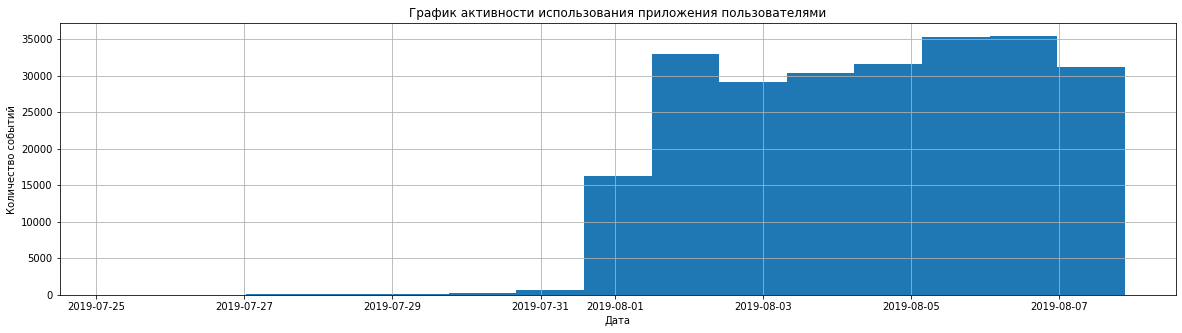

In [24]:
data['date_time'].hist(bins = 15, figsize=(20,5))
plt.title('График активности использования приложения пользователями')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

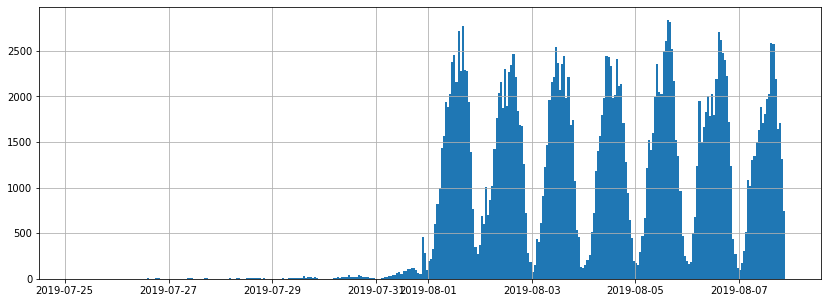

In [25]:
data['date_time'].hist(bins=14*24, figsize=(14, 5));

До 1 августа 2019г. пользователи не активно использовали приложение. Наиболее полные данные имеем с 01.08.2019, сдеалем срез данных с этой даты для дальнейшего анализа.

In [26]:
data_for_analyze = data.query('date_time >= "2019-08-01"').reset_index(drop = True)

In [27]:
data_for_analyze.head()

,event_name,device_id_hash,event_time_stamp,exp_id,date_time,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Определим, сколько событий потеряно в результате отброса старых данных:

In [28]:
data_loss_events = data.groupby('event_name').agg({'device_id_hash':'count'}).sort_values(by='device_id_hash', ascending = False)
data_loss_events['Число событий после фильтра данных, ед.'] = data_for_analyze.groupby('event_name').agg({'device_id_hash':'count'}).sort_values(by='device_id_hash', ascending = False)
data_loss_events['процент потерь каждого из событий, %'] = data_loss_events['Число событий после фильтра данных, ед.']/data_loss_events['device_id_hash']*100-100
data_loss_events.rename(columns={'device_id_hash':'Число событий до фильтра данных, ед.'}, inplace = True)
data_loss_events = data_loss_events.style.format({'процент потерь каждого из событий, %': '{:.2f}%'})
data_loss_events

,"Число событий до фильтра данных, ед.","Число событий после фильтра данных, ед.","процент потерь каждого из событий, %"
event_name,,,
MainScreenAppear,119101,117328,-1.49%
OffersScreenAppear,46808,46333,-1.01%
CartScreenAppear,42668,42303,-0.86%
PaymentScreenSuccessful,34118,33918,-0.59%
Tutorial,1018,1005,-1.28%


До фильтра старых данных в логе было 243 713 событий, после стало 240 887 событий. Общая сумма потери - 2 826 события (что составляет 1,16% потерь от изначального количества событий). Больше всего потерь у события MainScreenAppear - 1.49%.

Определим количество пользователей после фильтрации данных:

In [29]:
count_new_user = data_for_analyze['device_id_hash'].nunique()
count_new_user

7534

До отбрасывания старых данных пользователей было 7 551 чел., после фильтрации 7 534 чел. - потери в данных 17 человек (что составляет 0.2%).

In [30]:
data_cev = data_for_analyze.groupby('exp_id').agg({'device_id_hash':'nunique'}).sort_values(by='device_id_hash', ascending = False)
data_cev['Количество пользователей до фильтрации, ед.'] = data.groupby('exp_id').agg({'device_id_hash':'nunique'}).sort_values(by='device_id_hash', ascending = False)
data_cev['процент потерь пользователей по группам, %'] = data_cev['device_id_hash']/data_cev['Количество пользователей до фильтрации, ед.']*100-100
data_cev.rename(columns={'device_id_hash':'Количество пользователей после фильтрации, ед.'}, inplace = True)
data_cev = data_cev.style.format({'процент потерь пользователей по группам, %': '{:.2f}%'})
data_cev

,"Количество пользователей после фильтрации, ед.","Количество пользователей до фильтрации, ед.","процент потерь пользователей по группам, %"
exp_id,,,
248,2537,2542,-0.20%
247,2513,2520,-0.28%
246,2484,2489,-0.20%


In [31]:
exp_id_246 = data_for_analyze[data_for_analyze['exp_id']==246]
q246 = exp_id_246['device_id_hash'].nunique()
print (f"количество пользователей в группе 246: {q246} чел.")

exp_id_247 = data_for_analyze[data_for_analyze['exp_id']==247]
q247 = exp_id_247['device_id_hash'].nunique()
print (f"количество пользователей в группе 247: {q247} чел.")

exp_id_248 = data_for_analyze[data_for_analyze['exp_id']==248]
q248 = exp_id_248['device_id_hash'].nunique()
print (f'количество пользователей в группе "248": {q248} чел.')


количество пользователей в группе 246: 2484 чел.
количество пользователей в группе 247: 2513 чел.
количество пользователей в группе "248": 2537 чел.


- До фильтрации в группе "246" было 2489 человек (стало 2484 -0.2%)
- До фильтрации в группе "247" было 2520 человек (стало 2513 -0.3%)
- До фильтрации в группе "248" было 2542 человек (стало 2537 -0.2%)

# Изучение воронки событий

Таким образом, исходя из имеющихся отфильтрованных данных, можно выделить следующие события, совершаемые пользователями:

In [32]:
data_new_events = data_for_analyze.groupby('event_name').agg({'device_id_hash':'count'}).sort_values(by='device_id_hash', ascending = False)
data_new_events.rename(columns={'device_id_hash':'Количество событий, ед.'}, inplace = True)
data_new_events['Частота наступления события, %'] = data_new_events['Количество событий, ед.']/data_new_events['Количество событий, ед.'].sum()*100
data_new_events = data_new_events.style.format({'Частота наступления события, %': '{:.2f}%'})
data_new_events

,"Количество событий, ед.","Частота наступления события, %"
event_name,,
MainScreenAppear,117328,48.71%
OffersScreenAppear,46333,19.23%
CartScreenAppear,42303,17.56%
PaymentScreenSuccessful,33918,14.08%
Tutorial,1005,0.42%


Чаще всего пользователи совершают следующие события:
- зайти на главный экран (MainScreenAppear): событие произошло 117 328 раз;
- зайти на экран выбора товара (экран предложений) (OffersScreenAppear): событие произошло 46 333 раза;
- зайти в "корзину" (CartScreenAppear): событие произошло 42 303 раза;
- успешно оплатить товар (PaymentScreenSuccessful): событие произошло 33 918 раз;
- зайти на экран руководства/справки (Tutorial): событие произошло 1005 раз.

Большая часть произошедших событий - открытие главного экрана - 48.71% от общего числа событий. На экран выбора товара приходится 19.23% пользователей, на экран "корзины покупок" приходится 17.56% всех событий, а на экран успешного совершенного платежа - 14.08% событий. Справка/руководство пользуется наименьшей популярностью - 0.42%: либо совсем не заметно расположение справки на сайте, либо совсем не интересен этот этап знакомства с сайтом и процессом выбора товара, и его дальнейшей оплатой пользователям.

Посчитаем, сколько пользователей совершали каждое из этих событий

In [33]:
users_count = data_for_analyze.groupby('event_name').agg({'event_name':'count','device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
users_count.rename(columns={'device_id_hash':'Количество пользователей, чел.', 'event_name':'Количество событий, ед.'}, inplace = True)
users_count['Доля пользователей, хоть раз совершивших событие, %'] = users_count['Количество пользователей, чел.']/count_new_user*100
users_count = users_count.style.format({'Доля пользователей, хоть раз совершивших событие, %': '{:.2f}%'})
users_count

,"Количество событий, ед.","Количество пользователей, чел.","Доля пользователей, хоть раз совершивших событие, %"
event_name,,,
MainScreenAppear,117328,7419,98.47%
OffersScreenAppear,46333,4593,60.96%
CartScreenAppear,42303,3734,49.56%
PaymentScreenSuccessful,33918,3539,46.97%
Tutorial,1005,840,11.15%


Исходя из полученных данных по доле пользователей, хоть раз совершивших определенное событие, сделаем следующие выводы:
1. 98.47% пользователей из общего числа открывают главный экран (вероятно оставшиеся 2.53% посещают страницы сайта сразу из закладок в браузере);
2. 60.96% пользователей заходят на страницу выбора товара;
3. 49.56% пользователей выбирают товар и кладут его в корзину;
4. 46.97% пользователей оплачивают товар.
5. 11.15% пользователей просматривают руководство.

**Графически определим динамику событий по числу пользователей и долю пользователей, совершивших хотя бы одно событие**

In [34]:
events_table = data_for_analyze.groupby('event_name').agg({'event_name':'count', 'device_id_hash':'nunique'}).sort_values(by='device_id_hash', ascending=False)
events_table.columns = ['events_count', 'users_count']
events_table = events_table.reset_index()
events_table['users_action_once'] = (events_table['users_count'] / count_new_user * 100).round(1) 
events_table

,event_name,events_count,users_count,users_action_once
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0
4,Tutorial,1005,840,11.1


Построим график распределения событий по числу пользователей:

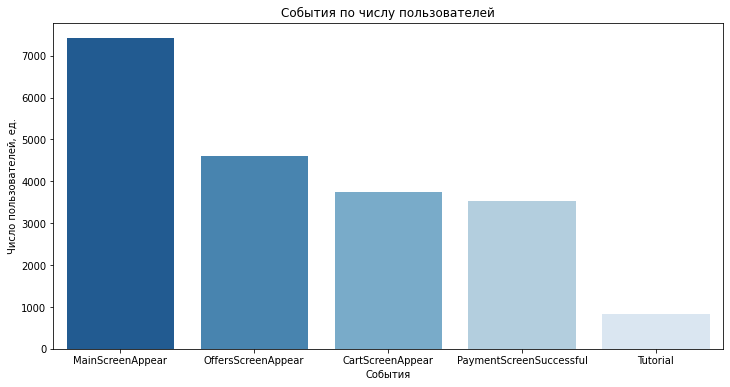

In [35]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-muted')
ax = sns.barplot(y='users_count', x='event_name', data=events_table, palette='Blues_r')
plt.xlabel('События')
plt.ylabel('Число пользователей, ед.')
plt.title('События по числу пользователей')
plt.show()

Построим график распределения долей пользователей, совершивших хотя бы одно событие

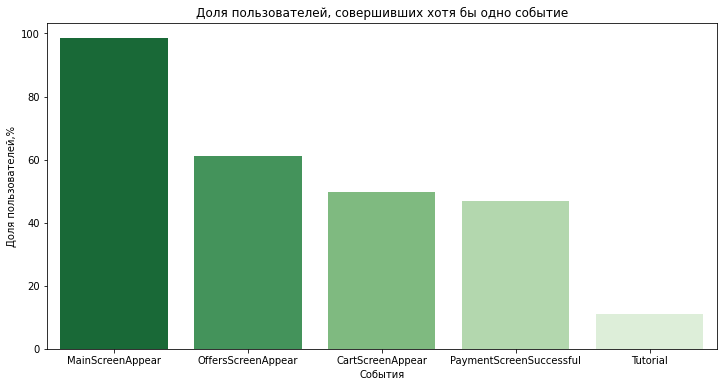

In [36]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-muted')
ax = sns.barplot(y='users_action_once', x='event_name', data=events_table, palette='Greens_r')
plt.xlabel('События')
plt.ylabel('Доля пользователей,%')
plt.title('Доля пользователей, совершивших хотя бы одно событие')
plt.show()

На графике также заметна цепочка последовательности совершения событий.

Определим порядок проведения событий:
Исходя из количества совершенных событий прослеживается четкая цепочка совершаемых действий пользователями:
1. Зайти на главную страницу (MainScreenAppear)
2. Зайти на экран выбора товара (OffersScreenAppear)
3. Зайти в "корзину" (CartScreenAppear)
4. Успешно оплатить товар (PaymentScreenSuccessful)

Посещение раздела сайта с руководством (Tutorial) не пользуется популярностью. Его можно удалить из воронки продаж. Однако, нужно быть уверенным, что этот раздел не интересен ни одной из экспериментальных групп. Проверим долю пользователей, кот. заходят в Tutorial по группам.

In [37]:
events_group = data_for_analyze.groupby(['event_name','exp_id']).agg({'event_name':'count', 'device_id_hash':'nunique'})
events_group.columns = ['events_count', 'users_count']
events_group = events_group.reset_index()

A246_users = data_for_analyze[data_for_analyze['exp_id']==246]['device_id_hash'].nunique()
A247_users = data_for_analyze[data_for_analyze['exp_id']==247]['device_id_hash'].nunique()
B248_users = data_for_analyze[data_for_analyze['exp_id']==248]['device_id_hash'].nunique()

def users_by_group(row):
    if row['exp_id'] == 246:
        return (row['users_count'] / A246_users*100)
    elif row['exp_id'] == 247:
        return (row['users_count'] / A247_users*100)
    elif row['exp_id'] == 248:
        return (row['users_count'] / B248_users*100)

events_group['users_action_once'] = events_group.apply(users_by_group, axis=1).round(2)
events_group.sort_values(by=['exp_id','users_count'], ascending=False).reset_index(drop=True)

,event_name,exp_id,events_count,users_count,users_action_once
0,MainScreenAppear,248,40562,2493,98.27
1,OffersScreenAppear,248,16387,1531,60.35
2,CartScreenAppear,248,15179,1230,48.48
3,PaymentScreenSuccessful,248,12085,1181,46.55
4,Tutorial,248,350,279,11.00
5,MainScreenAppear,247,39090,2476,98.53
6,OffersScreenAppear,247,15179,1520,60.49
7,CartScreenAppear,247,12434,1238,49.26
8,PaymentScreenSuccessful,247,9981,1158,46.08
9,Tutorial,247,338,283,11.26


Видим, что доля посещения раздела Tutorial пользователями каждой из групп колеблется в пределах 11% от общего количества конкретной группы.

Удалим раздел с руководством (Tutorial) из воронки продаж.

In [38]:
new_event_name = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
data_sales = data_for_analyze.query('event_name in @new_event_name').reset_index(drop = True)
data_sales

,event_name,device_id_hash,event_time_stamp,exp_id,date_time,date
0,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
3,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
4,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
...,...,...,...,...,...,...
239877,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
239878,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
239879,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
239880,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [39]:
data_sales['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: event_name, dtype: int64

Оределим долю пользователей, которая проходит на следующий шаг воронки:

In [40]:
previous_user = events_table.loc[0,'users_count']
start_user = previous_user
for i in events_table.index:
    events_table.loc[i,'Пользователи, перешедшие на следующий шаг,%'] = (events_table.loc[i,'users_count']/previous_user*100).round(1)
    events_table.loc[i,'Доля пользователей относительно первого события, %'] = (events_table.loc[i,'users_count'] / start_user * 100).round(1)
    previous_user = events_table.loc[i,'users_count']
events_table.query('event_name in @new_event_name')

,event_name,events_count,users_count,users_action_once,"Пользователи, перешедшие на следующий шаг,%","Доля пользователей относительно первого события, %"
0,MainScreenAppear,117328,7419,98.5,100.0,100.0
1,OffersScreenAppear,46333,4593,61.0,61.9,61.9
2,CartScreenAppear,42303,3734,49.6,81.3,50.3
3,PaymentScreenSuccessful,33918,3539,47.0,94.8,47.7


Как видим из анализа долей пользователей, перешедших на следующий шаг - наибольшее "проседание" наблюдается при переходе с главной страницы на страницу выбора заказов(-38.1%). При дальнейших переходах на страницу корзины и оплаты - больших потерь уже не наблюдается. Возможно, имеются определенные проблемы на главной странице - поскольку теряется более 1/3 пользователей. До оплаты доходит 47.7% пользователей, посетивших первую страницу.

Определим количество пользователей в каждой экспериментальной групп

In [41]:
for i in [246,247,248]:
    print(f"Группа {i} включает в себя {data_sales[data_sales['exp_id']==i]['device_id_hash'].nunique()} пользователей")

Группа 246 включает в себя 2483 пользователей
Группа 247 включает в себя 2512 пользователей
Группа 248 включает в себя 2535 пользователей


- Подготовим данные для проведения и анализа тестов (А/А, А/В эксперименты), а также расчета статистических критериев:

Переименуем названия групп 246 на А, 247 на А_, 248 на В для упрощения проведения и интерпретации результатов статистических расчетов.

In [42]:
data_sales['exp_id']  = data_sales['exp_id'].apply(lambda x: 'A' if x==246 else ('A_' if x==247 else 'B'))
data_sales['exp_id'].value_counts()

B     84213
A     78985
A_    76684
Name: exp_id, dtype: int64

In [43]:
# создадим комбинированный столбец АА_
users_bygroup = data_sales.groupby('exp_id')['device_id_hash'].nunique()
users_bygroup ['AA_'] = users_bygroup ['A']+users_bygroup ['A_']
users_bygroup

exp_id
A      2483
A_     2512
B      2535
AA_    4995
Name: device_id_hash, dtype: int64

Определим наиболее популярное событие и сколько процентов пользователей его совершили из каждой экспериментальной группы.

In [44]:
users_bygroup = data_sales.groupby('exp_id')['device_id_hash'].nunique()
test_table = data_sales.pivot_table(
    index='event_name', 
    columns='exp_id', 
    values='device_id_hash',
    aggfunc='nunique').sort_values(by='A', ascending=False)

test_table = test_table.reset_index()
test_table['AA_'] = test_table['A'] + test_table['A_']
test_table['all'] = test_table['A'] + test_table['A_'] + test_table['B']
test_table['ratio A'] = (test_table['A'] / users_bygroup['A'] * 100).round(1)
test_table['ratio A_'] = (test_table['A_'] / users_bygroup['A_'] * 100).round(1)
test_table['ratio B'] = (test_table['B'] / users_bygroup['B'] * 100).round(1)
test_table['ratio A_A'] = ((test_table['A'] + test_table['A_']) / (users_bygroup['A'] + users_bygroup['A_']) * 100).round(1)
test_table

exp_id,event_name,A,A_,B,AA_,all,ratio A,ratio A_,ratio B,ratio A_A
0,MainScreenAppear,2450,2476,2493,4926,7419,98.7,98.6,98.3,98.6
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.4,61.3
2,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.2


**1.** Самым популярным событием является открытие главной страницы (MainScreenAppear). Данное событие совершило 7 419 пользователей приложения:
- Из группы А (246) - 2450 человек;
- Из группы А_ (247) - 2476 человек;
- Из группы В (248) - 2493 человек.

**2.** Доля пользователей, совершивших это событие - 98.5% (расчитана при определении воронки продаж). По экспериментальным группам структура следующая:
- Группа А (246): 98.7%
- Группа А_ (247): 98.6%
- Группа В (248): 98.3%


**Напишем функцию, сравнивающую группы и проверяющую статистическую значимость.**

Степень различия ключевых метрик по группам зависит от необходимой чувствительности эксперимента. Для A/A-теста критерием успешности будет использование alpha 1%, так как по заданию эти группы одинаковы. 

Для A/B теста не требуется высокая точность, вследствии этого для него будет использован стандартный уровень значимости alpha  5%. 

In [45]:
def test(group1, group2, alpha):
    for i in test_table.index:
        p1 = test_table[group1][i] / users_bygroup[group1]
        p2 = test_table[group2][i] / users_bygroup[group2]
        p_all = ((test_table[group1][i] + test_table[group2][i]) / (users_bygroup[group1] + users_bygroup[group2]))
        z_value = (p1 - p2) / mth.sqrt(p_all * (1 - p_all) * (1 / users_bygroup[group1] + 1 / users_bygroup[group2]))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(test_table['event_name'][i], p_value))
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('')

Гипотезы:

H0: Отсутствует статистическая значимость в отличии в долях пользователей, перешедших на следующий этап воронки. Нет оснований считать доли разными.

H1: Присутствует статистическая значимость в отличии в долях пользователей, перешедших на следующий этап воронки. Есть основания считать доли разными.



**A/A тест**

In [46]:
test('A', 'A_', 0.01)

MainScreenAppear p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**А/В тест**

In [47]:
test('A', 'B', 0.05)

MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**A_/B тест**

In [48]:
test('A_', 'B', 0.05)

MainScreenAppear p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**АА_/В тест**

In [53]:
test_table

exp_id,event_name,A,A_,B,AA_,all,ratio A,ratio A_,ratio B,ratio A_A
0,MainScreenAppear,2450,2476,2493,4926,7419,98.7,98.6,98.3,98.6
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.4,61.3
2,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.2


In [55]:
users_bygroup

exp_id
A     2483
A_    2512
B     2535
Name: device_id_hash, dtype: int64

Таким образом, проведенный АА тест позволил сделать вывод о предварительных результатах А/В теста. Две контрольные группы оказались практически равными, что можно трактовать как достигнутую точность в проведимом исследовании. Возможно предлагаемые шрифты стоит использовать в приложении. Статистической значимости в изменении долей пользователей, переходящих на страницы в мобильном приложенни нет: ни в контрольных группах, ни в экспериментальной. Пользователи также продолжают пользоваться приложением, что и до нововведений со шрифтами.

In [ ]:
alpha = 0.05  # критический уровень статистической значимости

results_AB = st.ttest_ind(test_table['A'], test_table['B'])

results_AA_ = st.ttest_ind(test_table['A'], test_table['A_'])

results_A_B = st.ttest_ind(test_table['A_'], test_table['B'])

results_AA_B = st.ttest_ind(test_table['AA_'], test_table['B'])


bonferroni_alpha = alpha /16  # произведено шестнадцать сравнений

print('p-значение для сравнения групп А и B: ', results_AB.pvalue)
print('p-значение для сравнения групп А и А_ ', results_AA_.pvalue)
print('p-значение для сравнения групп А_ и B: ', results_A_B.pvalue)
print('p-значение для сравнения групп АA_ и B: ', results_AA_B.pvalue)

if results_AB.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_AA_.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и А_')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и А_'
    )

if results_A_B.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А_ и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А_ и B'
    ) 

if results_AA_B.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп АA_ и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп АA_ и B'
    ) 

Результаты получающихся p-value - почти все они намного больше установленного нами уровня альфа (0.05). Поэтому можно сделать вывод о том, что можно оставить уровень значимости, например, 0.05. От этого наши выводы по проверке гипотез не изменятся - отличия в долях пользователей, совершивших события, не являются статистически значимыми.

# Выводы:




Перед исследованием поведения пользователей мобильного приложения магазина была проведена предобработка данных:
1. Был изменен регистр и приведено названия столбцов к наиболее подходящему для работы виду;
2. Данные были проверены на наличие пропусков, дубликатов, проанализирована корректность типов данных:
 - дубликаты были удалены;
 - типы данных в графе даты были изменены на соответствующие;

При исследовательском анализе данных было определено, что пользователи участвуют в выполнении следующих событий:
- зайти на главный экран (**MainScreenAppear**): событие произошло 119 101 раз;
- зайти на экран выбора товара (экран предложений) (**OffersScreenAppear**): событие произошло 46 808 раз;
- зайти в "корзину" (**CartScreenAppear**): событие произошло 42 668 раз;
- успешно оплатить товар (**PaymentScreenSuccessful**): событие произошло 34 118 раз;
- зайти на экран руководства/справки (**Tutorial**): событие произошло 1018 раз.

Выяснено, что В среднем на одного пользователя приходится 32 события.

При анализе графика активности использования приложения пользователями удалось определить, что до 1 августа 2019г. пользователи не активно использовали приложение. Наиболее полные данные имеем с 01.08.2019, был сдеалан срез данных с этой даты для дальнейшего анализа. До фильтра старых данных в логе было 243 713 событий, после стало 240 887 событий. Общая сумма потери - 2 826 события (что составляет 1,16% потерь от изначального количества событий). Больше всего потерь у события MainScreenAppear - 1.49%. До отбрасывания старых данных пользователей было 7 551 чел., после фильтрации 7 534 чел. - потери в данных 17 человек (что составляет 0.2%).

После фильтрации данных определено, что чаще всего пользователи совершают следующие события:
- зайти на главный экран (MainScreenAppear): событие произошло 117 328 раз;
- зайти на экран выбора товара (экран предложений) (OffersScreenAppear): событие произошло 46 333 раза;
- зайти в "корзину" (CartScreenAppear): событие произошло 42 303 раза;
- успешно оплатить товар (PaymentScreenSuccessful): событие произошло 33 918 раз;
- зайти на экран руководства/справки (Tutorial): событие произошло 1005 раз.

Большая часть произошедших событий - открытие главного экрана - 48.71% от общего числа событий. На экран выбора товара приходится 19.23% пользователей, на экран "корзины покупок" приходится 17.56% всех событий, а на экран успешного совершенного платежа - 14.08% событий. Справка/руководство пользуется наименьшей популярностью - 0.42%: либо совсем не заметно расположение справки на сайте, либо совсем не интересен этот этап знакомства с сайтом и процессом выбора товара, и его дальнейшей оплатой пользователям.


Исходя из полученных данных по доле пользователей, хоть раз совершивших определенное событие, сделаем следующие выводы:
1. 98.47% пользователей из общего числа открывают главный экран (вероятно оставшиеся 2.53% посещают страницы сайта сразу из закладок в браузере);
2. 60.96% пользователей заходят на страницу выбора товара;
3. 49.56% пользователей выбирают товар и кладут его в корзину;
4. 46.97% пользователей оплачивают товар.
5. 11.15% пользователей просматривают руководство.

Был определен порядок проведения событий:
Исходя из количества совершенных событий прослеживается четкая цепочка совершаемых действий пользователями:
1. Зайти на главную страницу (MainScreenAppear)
2. Зайти на экран выбора товара (OffersScreenAppear)
3. Зайти в "корзину" (CartScreenAppear)
4. Успешно оплатить товар (PaymentScreenSuccessful)

Посещение раздела сайта с руководством (Tutorial) не пользуется популярностью. Было принято решение об удалении его из воронки продаж.

Оределена доля пользователей, которая проходит на следующий шаг воронки:

из анализа долей пользователей, перешедших на следующий шаг - наибольшее "проседание" наблюдается при переходе с главной страницы на страницу выбора заказов(-38.1%). При дальнейших переходах на страницу корзины и оплаты - больших потерь уже не наблюдается. Возможно, имеются определенные проблемы на главной странице - поскольку теряется более 1/3 пользователей. До оплаты доходит 47.7% пользователей, посетивших первую страницу.

Были подготовлены данные для проведения и анализа тестов (А/А, А/В эксперименты), а также расчета статистических критериев.

Выяснено, что:

1. Самым популярным событием является открытие главной страницы (MainScreenAppear). Данное событие совершило 7 419 пользователей приложения:

Из группы А (246) - 2450 человек;
Из группы А_ (247) - 2476 человек;
Из группы В (248) - 2493 человек.
2. Доля пользователей, совершивших это событие - 98.5% (расчитана при определении воронки продаж). По экспериментальным группам структура следующая:

Группа А (246): 98.7%
Группа А_ (247): 98.6%
Группа В (248): 98.3%

Проведены АА, А/В, А_/В, АА_/В тесты. По результатам которых на каждом из событий не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Таким образом, проведенный АА тест позволил сделать вывод о предварительных результатах А/В теста. Две контрольные группы оказались практически равными, что можно трактовать как достигнутую точность в проведимом исследовании. Возможно предлагаемые шрифты стоит использовать в приложении. Статистической значимости в изменении долей пользователей, переходящих на страцийы в мобильном приложенни нет: ни в контрольных группах, ни в экспериментальной. Пользователи также продолжают пользоваться приложением, что и до нововведений со шрифтами.

Результаты получающихся p-value - почти все они намного больше установленного нами уровня альфа (0.05). Поэтому можно сделать вывод о том, что можно оставить уровень значимости, например, 0.05. От этого наши выводы по проверке гипотез не изменятся - отличия в долях пользователей, совершивших события, не являются статистически значимыми.
